In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [2]:
!cp rab11_smFISH_train.ipynb scrib_smFISH_train.ipynb

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training

Load base config

In [65]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [6]:
cfg.output.project = 'scrib_smFISH'

cfg.run_name ='scrib_smFISH_2_2'
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_2.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None
cfg.microscope.psf_extent_zyx = [21,21,21]

cfg.bg_estimation.smoothing_filter_size = 3

cfg.foci.n_foci_avg = 1
cfg.microscope.multipl = 3
cfg.pointprocess.min_int = 0.15

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,200:250,150:200,:]'
cfg.evaluation.px_size =  [100,100,100]

cfg.PSF.gauss_radii = [1.5,1.0,1.0]
cfg.prob_generator.low= 0.0001
cfg.prob_generator.high= 0.001

Store the config as an experiment

In [7]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [8]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Plot projections of the volume

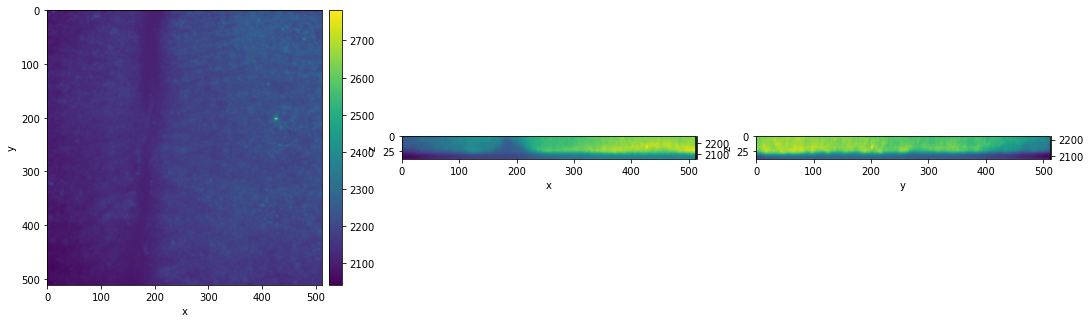

In [9]:
_ = plot_3d_projections(img_3d)

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

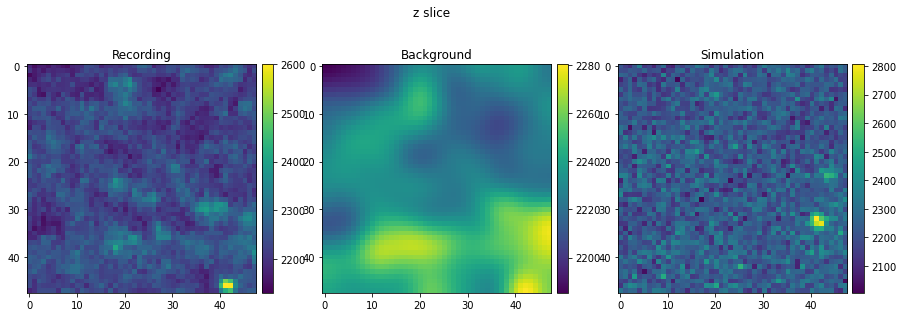

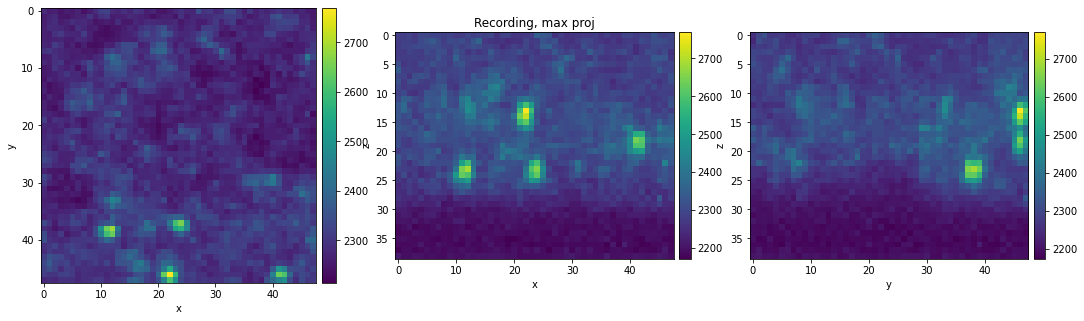

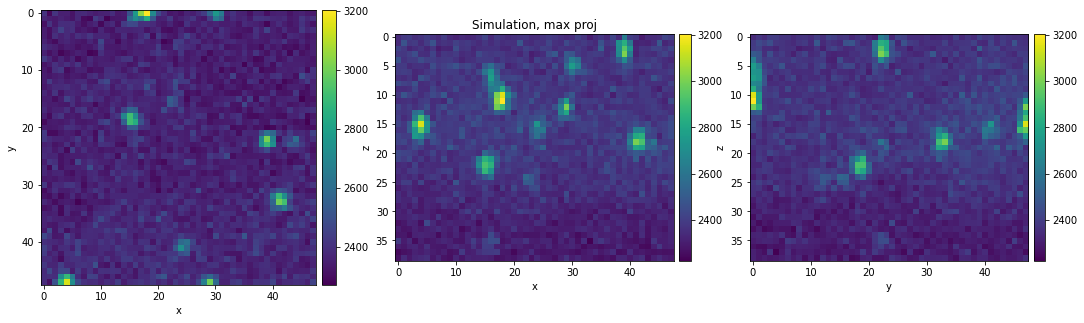

In [13]:
get_simulation_statistics(decode_dl, micro, int_threshold=1000)

Command to train a model on the gpu cluster

In [14]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=scrib_smFISH_2_2'

# Evaluation

In [18]:
cfg = OmegaConf.load(f'config/experiment/scrib_smFISH_2_2.yaml')
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_4.tif'

In [19]:
print(cfg.microscope.psf_noise)
cfg.microscope.psf_noise = 0
model = hydra.utils.instantiate(cfg.model)
model = load_model_state(model, cfg.output.save_dir, 'model.pkl')
psf_init, noise, micro = load_psf_noise_micro(cfg)
psf_init.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf_init.pkl'))
psf_init.cuda()
post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
psf, noise, micro = load_psf_noise_micro(cfg)
psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))
psf.cuda()

2e-05


LinearInterpolatedPSF()

In [20]:
img_3d, decode_dl = get_dataloader(cfg)

Plot projections of the PSF before and after optimizing it during training

tensor(1.0001, device='cuda:0', grad_fn=<SumBackward0>)

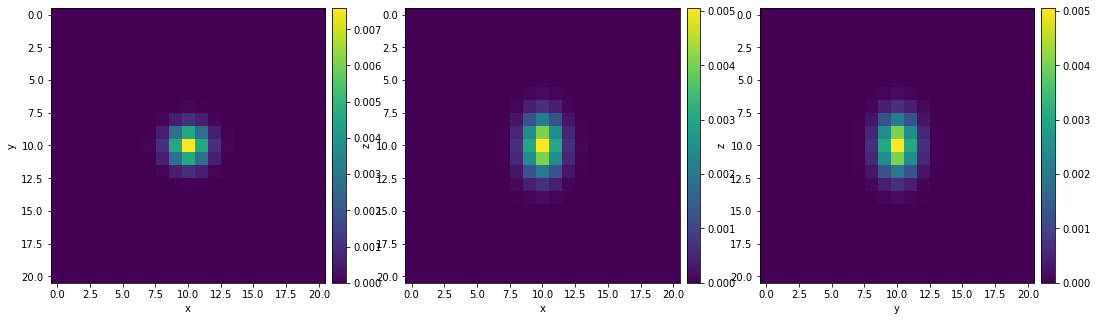

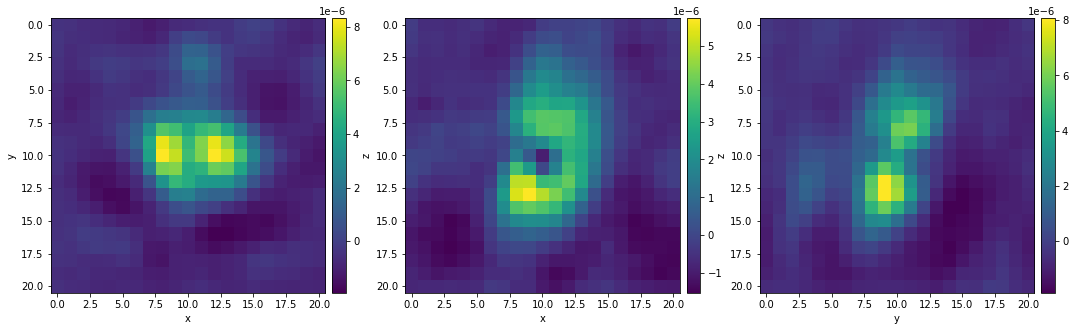

In [21]:
plot_3d_projections(psf.psf_volume[0])
plot_3d_projections(psf.psf_volume[0]-psf_init.psf_volume[0], 'mean')
psf.psf_volume[0].sum()

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

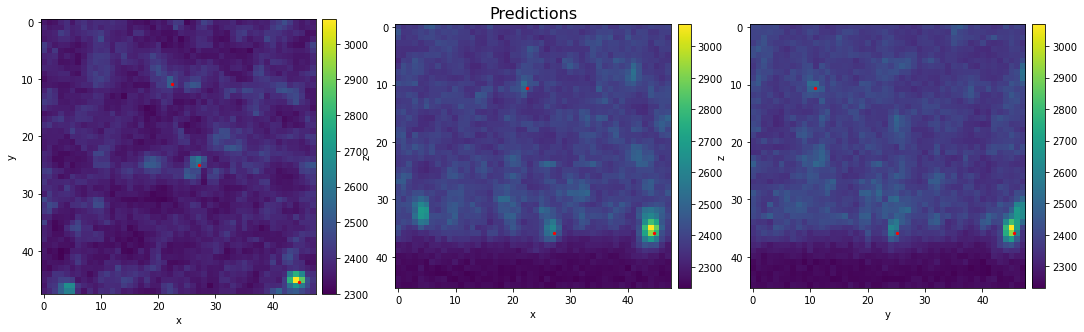

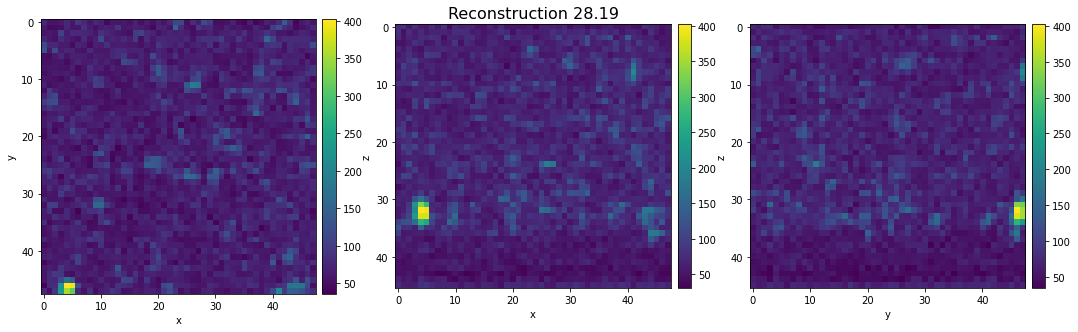

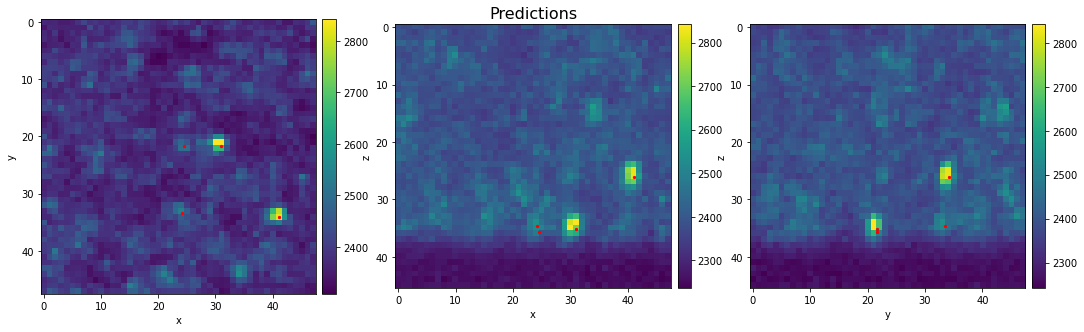

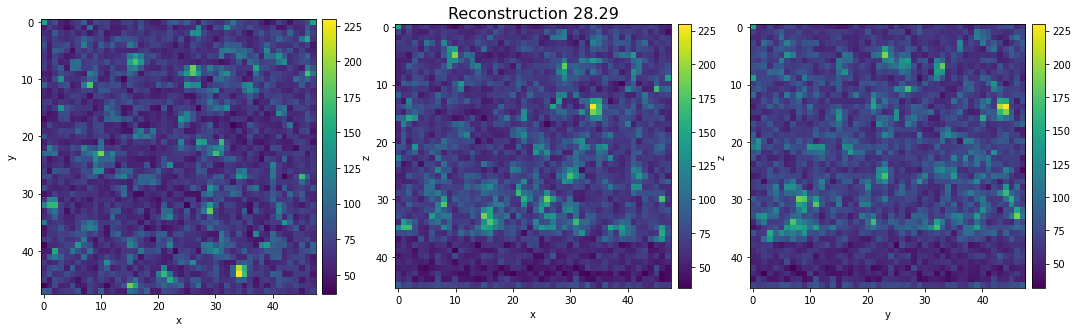

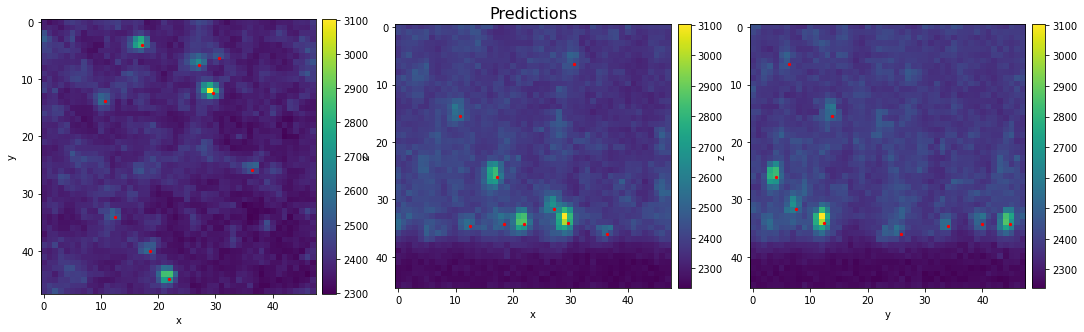

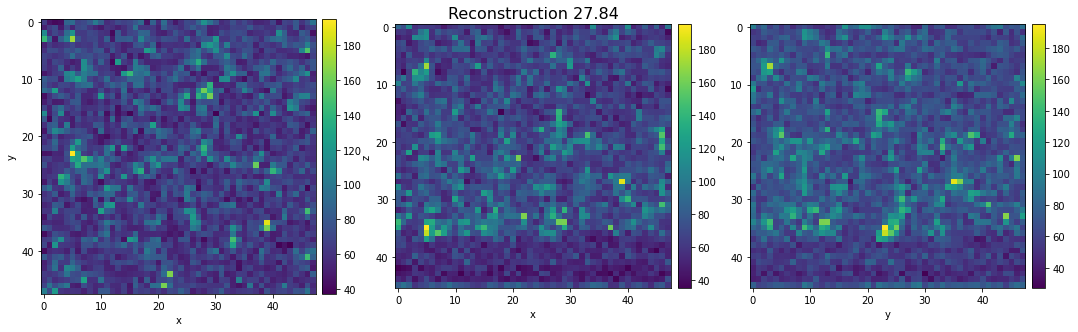

In [22]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

Volume with Foci? Max projection of real volume, reconstruction, difference

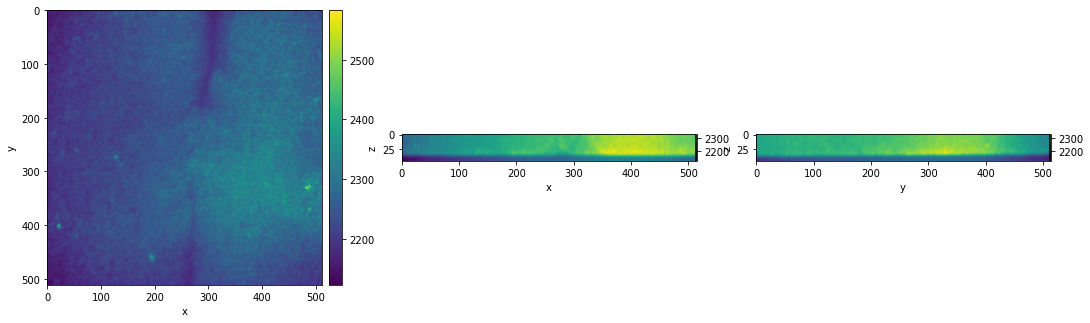

In [25]:
_ = plot_3d_projections(img_3d)

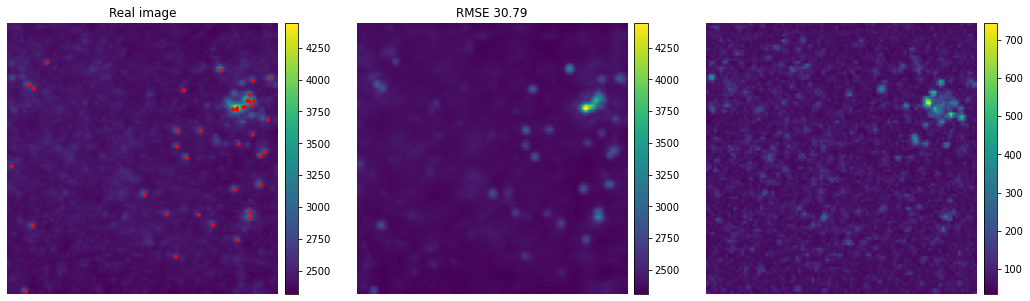

In [26]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,300:400,400:500], micro, return_rec=True, cuda=True, min_int=0.3)
_ = gt_plot(img_3d[:,300:400,400:500][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
# torch.save(res_dict, 'data/model_output_r.pt')

In [27]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])#.to('cuda'))
    pred_df = post_proc(res)
    free_mem()

Inferred intensities

753


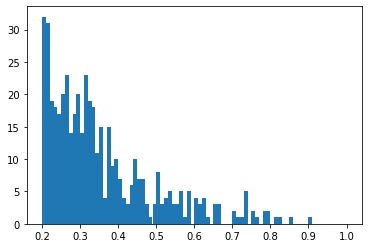

In [28]:
_ = plt.hist(pred_df['int'], bins=np.linspace(0.2,1,81))
print(len(pred_df))

In [ ]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
# vol = img_3d.numpy()

# extent = [[-s/2,s/2] for s in vol.shape]
# extent = [extent[i] for i in [2,1,0]]

# ipv.figure()
# ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
# ipv.xyzlim(max(vol.shape)/2)
# ipv.view(90, 40)
# ipv.show()